# Imports and Data Preparation

Some Ideas:
- Since this method requires labels, we could classiy different domains based on the labels. For example, if we have a data set of people sick with Creutzfeld-Jakob discease and the other domain is people who are sick with alzheimers. 

In [1]:
from MASH import MASH
import numpy as np
import pandas as pd
import test_manifold_algorithms as tma
from SPUD import SPUD
from rfgap import RFGAP
import matplotlib.pyplot as plt


#DC is short for data class
dc = tma.test_manifold_algorithms(csv_file="glass.csv", split = "distort", percent_of_anchors= [0.2], verbose = 2, random_state= 10)

2024-07-30 17:13:46.097582: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-30 17:13:46.103828: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-30 17:13:46.208699: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-30 17:13:48.623962: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



 
 
---------------------------       Initalizing class with glass.csv data       ---------------------------

Creating a mirror dataset and distorting the features in the second Domain
Split A features shape: (214, 9)
Split B Features shape (214, 9)
MDS initialized with 9 components
The knn values are: (2, 7, 12, 17, 22, 27, 32, 37, 42, 47)


In [2]:
#Create a normalize function
def normalize_0_to_1(value):
    """Normalizes the value to be between 0 and 1 and resets infinite values."""

    #Scale it and check to ensure no devision by 0
    if np.max(value[~np.isinf(value)]) != 0:

      value = (value - value.min()) / (value[~np.isinf(value)].max() - value.min()) 

    #Reset inf values
    value[np.isinf(value)] = 1

    return 1 - value

In [3]:
#Create a normalize function
def normalize_outliers(value):
    """Normalizes the value to be between 0 and 1 and resets infinite values."""

    value = np.array(value)

    #Scale it and check to ensure no devision by 0
    if np.max(value[~np.isinf(value)]) != 0:
      
      #Reduce outliers
      percentile = np.percentile(value, 75)

      #Reset the values to be the percentile
      value[value > percentile] = percentile

      value = (value - value.min()) / (value[~np.isinf(value)].max() - value.min()) 

    return 1- np.array(value)

In [4]:
def replace_with_ones(data):
    data = np.array(data)
    return np.ones(shape = data.shape)

# Preparing and Working though RF GAP

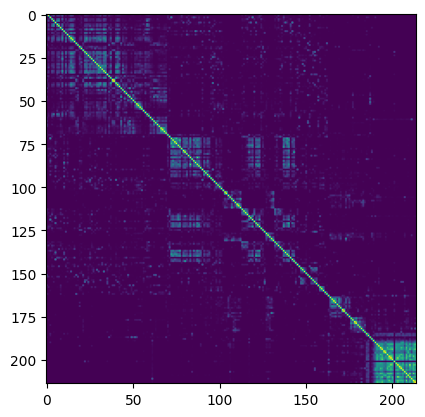

In [5]:
#Initilize Class
rf_class = RFGAP(prediction_type="classification", y=dc.labels, prox_method="rfgap", matrix_type= "dense", triangular=False, non_zero_diagonal=True)

#Fit it for Data A
rf_class.fit(dc.split_A, y = dc.labels) #y = dc.labels

#Get promities
dataA = rf_class.get_proximities()

#Show them
plt.imshow(rf_class.get_proximities())

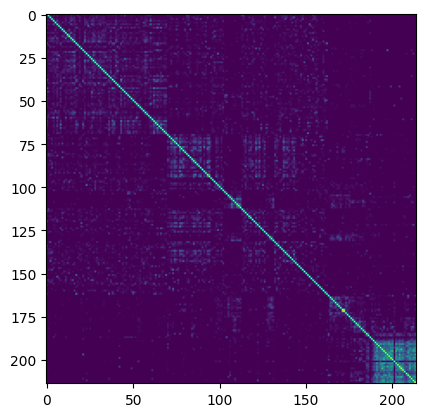

In [7]:
#Fit it for Class B
rf_class.fit(dc.split_B, y = dc.labels)

#Get promities
dataB = rf_class.get_proximities()

#Show them
plt.imshow(rf_class.get_proximities())

In [17]:
#Initialize SPUD Class
spud_class = SPUD(distance_measure_A = "euclidian", distance_measure_B= "euclidian", knn = 5, operation = 1.0, IDC = 1, verbose = 3)

#Fit SPUD
spud_class.fit(dataA = dataA, dataB = dataB, known_anchors = dc.anchors[:10])

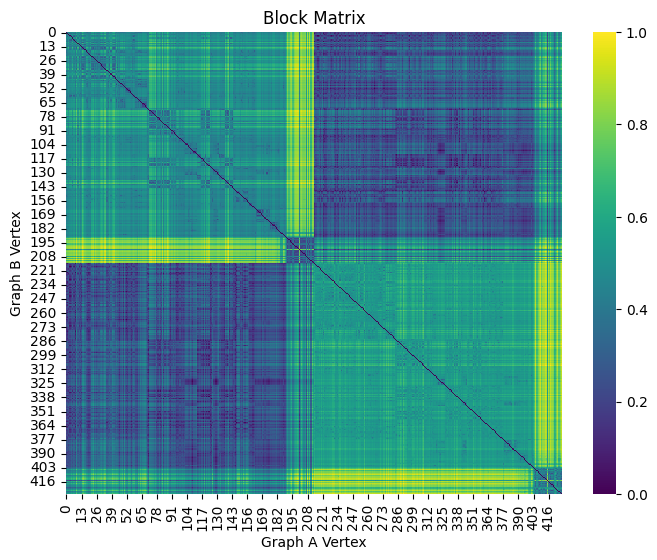

In [18]:
spud_class.plot_heat_map()

Cross Embedding: 0.48598130841121495
FOSCTTM: 0.3476067778845314


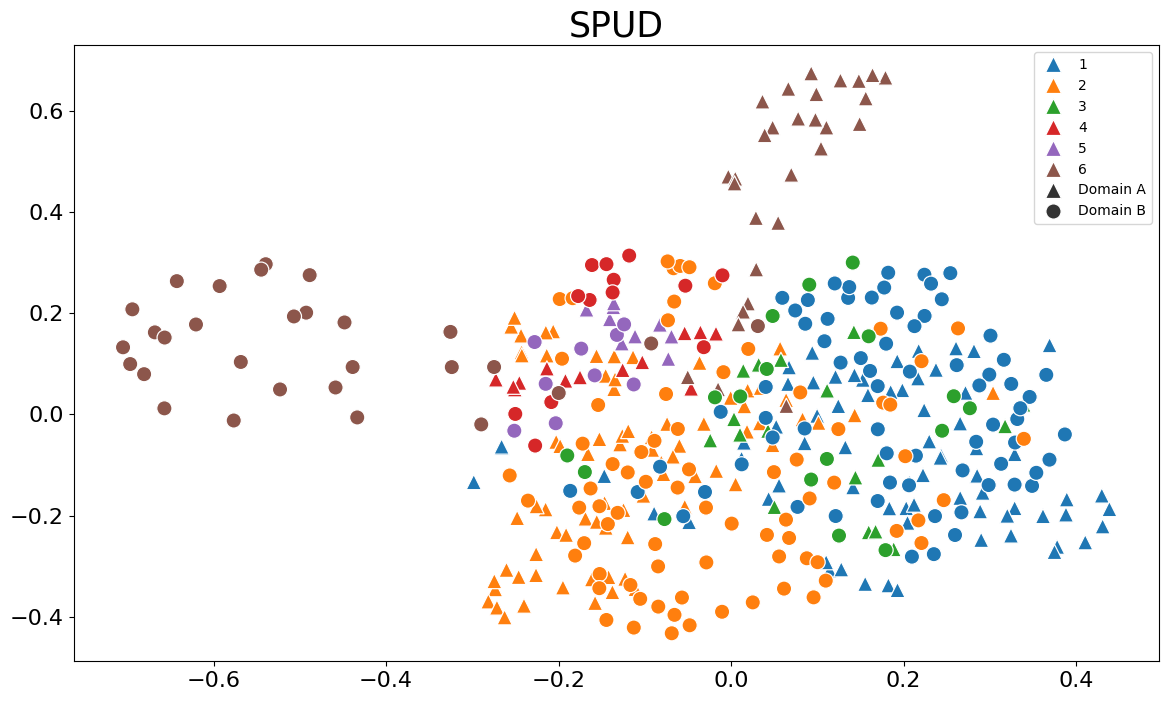

In [19]:
spud_class.plot_emb(labels = dc.labels_doubled, show_lines = False, show_anchors = False)

A few Things...

- First, we are giving it all of the labels to determine the proximity similarities. That is wrong.
- Second, its FOSCTTM score is awful
- Third, its CE score seems to be usually very good and the splits are great. 
- Additionally, it is not great with some csv files